In [ ]:
import os
import glob
import json
import random
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

import torchvision.models as models
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torchvision.transforms.functional import to_pil_image
from torchvision.datasets import ImageFolder
from PIL import Image

import albumentations as A
from albumentations.pytorch import ToTensorV2

# from google.colab import drive

from collections import Counter
from datetime import datetime

ModuleNotFoundError: No module named 'tensorflow'

In [2]:
# drive.mount('/content/drive')
# !pwd
# %cd drive/MyDrive/cse164
# !pwd

In [3]:
# Globals
BATCH_SIZE = 64
NUM_CLASSES = 50
CONF_THRESHOLD = 0.85
EPOCHS = 50
IMAGE_SIZE = 224
MODEL_SAVE_DIR = 'saved_models'

/home/charles/.local/lib/python3.10/site-packages/albumentations/core/validation.py:111: UserWarning: ShiftScaleRotate is a special case of Affine transform. Please use Affine transform instead.
  original_init(self, **validated_kwargs)


torch.Size([16, 3, 128, 128])
torch.Size([16])
torch.Size([16, 128, 128])


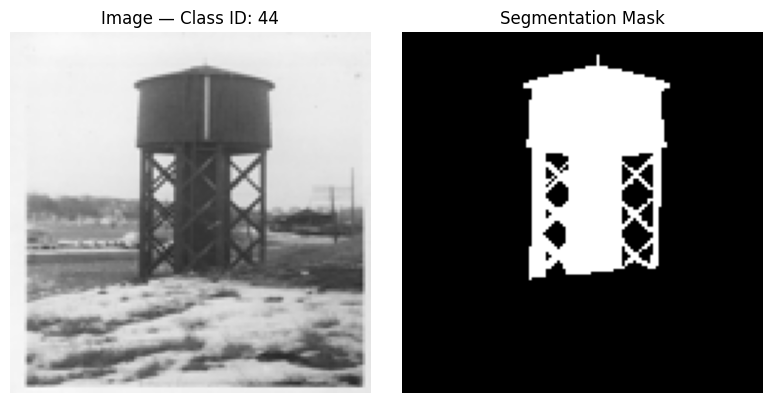

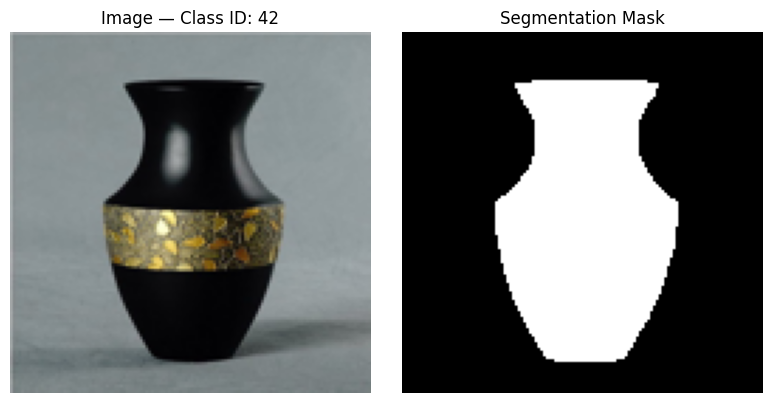

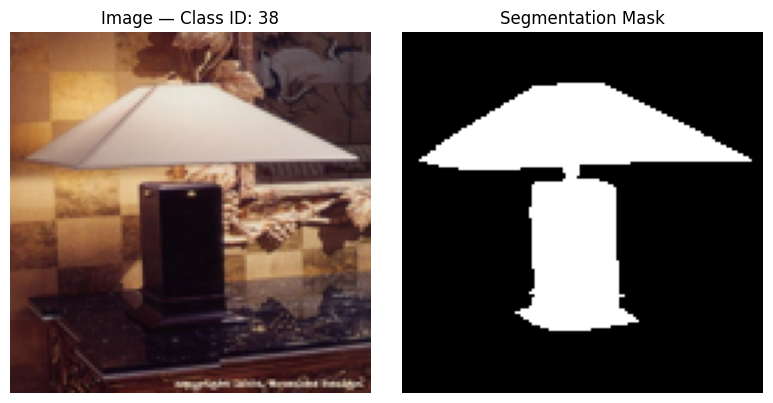

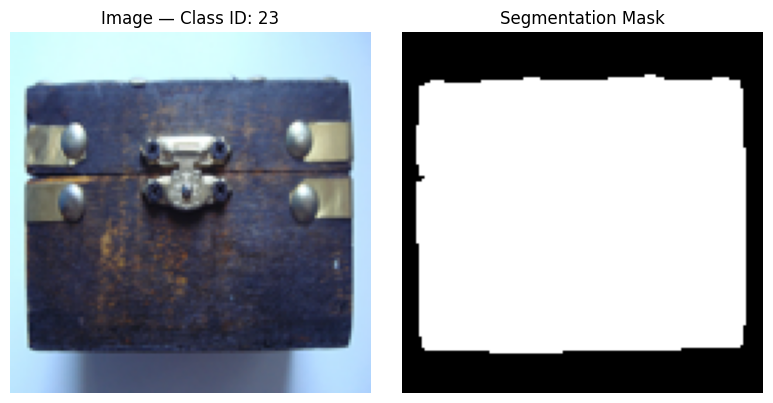

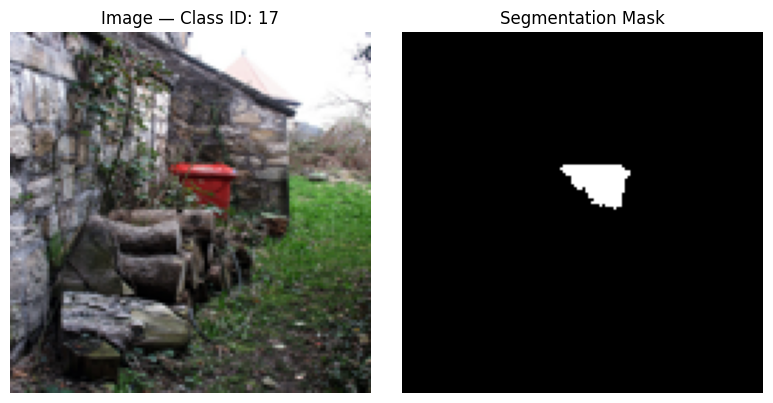

In [13]:
class ImageNetSubsetSegmentationDataset(Dataset):
    def __init__(self, json_path, image_size=(128, 128), mode='both', augmentation=None):
        self.image_dir = "train-semi"
        self.mask_dir = "train-semi-segmentation"
        self.mode = mode
        self.image_size = image_size
        self.augmentation = augmentation

        with open(json_path, "r") as f:
            self.samples = json.load(f)

        self.image_transform = transforms.Compose([
            transforms.Resize(image_size),
            transforms.ToTensor()
        ])

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        entry = self.samples[idx]
        image_rel = entry["image"]
        mask_rel = entry["mask"]
        class_id = entry["class_id"]

        image_path = os.path.join(self.image_dir, image_rel)
        if not os.path.exists(image_path):
            pattern = os.path.splitext(image_path)[0] + ".*"
            matches = glob.glob(pattern)
            if matches:
                image_path = matches[0]
            else:
                raise FileNotFoundError(f"Image not found: {image_rel}")

        mask_path = os.path.join(self.mask_dir, mask_rel)
        if not os.path.exists(mask_path):
            pattern = os.path.splitext(mask_path)[0] + ".*"
            matches = glob.glob(pattern)
            if matches:
                mask_path = matches[0]
            else:
                raise FileNotFoundError(f"Mask not found: {mask_rel}")

        # Load image and mask
        image = np.array(Image.open(image_path).convert("RGB"))
        mask = np.array(Image.open(mask_path).convert("RGB"))[..., 0]  # Take R channel

        # Apply augmentation
        if self.augmentation:
            augmented = self.augmentation(image=image, mask=mask)
            image = augmented['image'].float()
            mask = augmented['mask'].long()
        else:
            # Apply default resizing and tensor conversion if no augmentation
            image = Image.fromarray(image).resize(self.image_size)
            mask = Image.fromarray(mask).resize(self.image_size, resample=Image.NEAREST)
            image = transforms.ToTensor()(image)
            mask = torch.from_numpy(np.array(mask)).long()

        if self.mode == "classification":
            return image, class_id
        elif self.mode == "segmentation":
            return image, mask
        else:
            return image, class_id, mask

augmentation = A.Compose([
    A.Resize(128, 128),
    A.HorizontalFlip(p=0.5),
    A.ShiftScaleRotate(shift_limit=0.05, scale_limit=0.1, rotate_limit=15, p=0.5),
    ToTensorV2()
])

dataset = ImageNetSubsetSegmentationDataset(
    json_path="train_semi_annotations_with_seg_ids.json",
    mode='both',
    augmentation=None
)
dataloader = DataLoader(dataset, batch_size=16, shuffle=True)

# Inspect one batch
images, class_ids, masks = next(iter(dataloader))
print(images.shape)     # [16, 3, 128, 128]
print(class_ids.shape)  # [16]
print(masks.shape)      # [16, 128, 128]

def plot_segmentation(image, mask, class_id=None):
    fig, axs = plt.subplots(1, 2, figsize=(8, 4))
    axs[0].imshow(to_pil_image(image.cpu()))
    axs[0].set_title(f"Image" + (f" — Class ID: {class_id}" if class_id is not None else ""))
    axs[0].axis("off")

    axs[1].imshow(mask.cpu(), cmap="gray")
    axs[1].set_title("Segmentation Mask")
    axs[1].axis("off")
    plt.tight_layout()
    plt.show()

for i in range(5):
    plot_segmentation(images[i], masks[i], class_ids[i])

In [5]:
# --- Attention Block ---
class SEBlock(nn.Module):
    def __init__(self, channels, reduction=16):
        super(SEBlock, self).__init__()
        self.fc1 = nn.Linear(channels, channels // reduction)
        self.fc2 = nn.Linear(channels // reduction, channels)

    def forward(self, x):
        b, c, _, _ = x.size()
        y = F.adaptive_avg_pool2d(x, 1).view(b, c)
        y = F.relu(self.fc1(y))
        y = torch.sigmoid(self.fc2(y)).view(b, c, 1, 1)
        return x * y

# --- Conv Block with Dropout + Attention ---
def conv_block(in_c, out_c, dropout=0.0):
    layers = [
        nn.Conv2d(in_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
        nn.Conv2d(out_c, out_c, 3, padding=1),
        nn.BatchNorm2d(out_c),
        nn.ReLU(inplace=True),
    ]
    if dropout > 0:
        layers.append(nn.Dropout(dropout))
    layers.append(SEBlock(out_c))
    return nn.Sequential(*layers)

# --- Full UNet Model ---
class UNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=NUM_CLASSES):
        super(UNet, self).__init__()

        self.enc1 = conv_block(in_channels, 64)
        self.enc2 = conv_block(64, 128)
        self.enc3 = conv_block(128, 256)
        self.enc4 = conv_block(256, 512)

        self.pool = nn.MaxPool2d(2)

        self.bottleneck = conv_block(512, 1024)

        self.up3 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.dec3 = conv_block(1024, 512, dropout=0.3)

        self.up2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.dec2 = conv_block(512, 256, dropout=0.2)

        self.up1 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.dec1 = conv_block(256, 128, dropout=0.1)

        self.up0 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.dec0 = conv_block(128, 64)

        self.final = nn.Conv2d(64, out_channels, kernel_size=1)

    def forward(self, x):
        e1 = self.enc1(x)
        e2 = self.enc2(self.pool(e1))
        e3 = self.enc3(self.pool(e2))
        e4 = self.enc4(self.pool(e3))

        b = self.bottleneck(self.pool(e4))

        d3 = self.up3(b)
        d3 = torch.cat([d3, e4], dim=1)
        d3 = self.dec3(d3)

        d2 = self.up2(d3)
        d2 = torch.cat([d2, e3], dim=1)
        d2 = self.dec2(d2)

        d1 = self.up1(d2)
        d1 = torch.cat([d1, e2], dim=1)
        d1 = self.dec1(d1)

        d0 = self.up0(d1)
        d0 = torch.cat([d0, e1], dim=1)
        d0 = self.dec0(d0)

        out = self.final(d0)
        return out
        return F.softmax(out, dim=1)


In [6]:
class DiceLoss(nn.Module):
    def __init__(self, smooth=1.0):
        super(DiceLoss, self).__init__()
        self.smooth = smooth

    def forward(self, preds, targets):
        preds = F.softmax(preds, dim=1)
        preds_flat = preds.view(preds.size(0), preds.size(1), -1)
        targets_flat = F.one_hot(targets, preds.size(1)).permute(0, 3, 1, 2).reshape_as(preds_flat)

        intersection = (preds_flat * targets_flat).sum(2)
        union = preds_flat.sum(2) + targets_flat.sum(2)

        dice_score = (2 * intersection + self.smooth) / (union + self.smooth)
        return 1 - dice_score.mean()

# Combined loss
def combined_loss(preds, targets):
    ce = nn.CrossEntropyLoss()(preds, targets)
    dice = DiceLoss()(preds, targets)
    return ce + dice


In [7]:
def dice_score(preds, targets, smooth=1.0):
    preds = torch.argmax(preds, dim=1)
    preds_flat = preds.view(-1)
    targets_flat = targets.view(-1)
    intersection = (preds_flat == targets_flat).float().sum()
    total = preds_flat.numel() + targets_flat.numel()
    return (2.0 * intersection + smooth) / (total + smooth)

def iou_score(preds, targets, smooth=1.0):
    preds = torch.argmax(preds, dim=1)
    intersection = ((preds == targets) & (targets > 0)).float().sum()
    union = ((preds > 0) | (targets > 0)).float().sum()
    return (intersection + smooth) / (union + smooth)


In [8]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("using", device)
model = UNet(in_channels=3, out_channels=233).to(device)
# model = SimpleUNet(232 + 1).to(device)
criterion = nn.CrossEntropyLoss()  # expects (B, C, H, W) logits and (B, H, W) target
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

using cuda


In [14]:
num_epochs = 20

def validate(model, val_loader, device):
    model.eval()
    total_dice, total_iou, total_loss = 0, 0, 0

    with torch.no_grad():
        for images, class_id, masks in val_loader:
            images, masks = images.to(device), masks.to(device)

            outputs = model(images)
            total_loss += combined_loss(outputs, masks).item()
            total_dice += dice_score(outputs, masks).item()
            total_iou += iou_score(outputs, masks).item()

    n = len(val_loader)
    print(f"[Validation] Loss: {total_loss/n:.4f} | Dice: {total_dice/n:.4f} | IoU: {total_iou/n:.4f}")
    return total_loss/n, total_dice/n, total_iou/n

for epoch in range(num_epochs):
    model.train()
    epoch_loss = 0

    for images, class_id, masks in dataloader:
        images, masks = images.to(device), masks.to(device)

        optimizer.zero_grad()
        outputs = model(images)
        loss = combined_loss(outputs, masks)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()

    avg_train_loss = epoch_loss / len(dataloader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Train Loss: {avg_train_loss:.4f}")

    validate(model, dataloader, device)




Epoch [1/20], Train Loss: 5.6469
[Validation] Loss: 5.2498 | Dice: 0.6805 | IoU: 0.0005
Epoch [2/20], Train Loss: 5.5356
[Validation] Loss: 4.7794 | Dice: 0.6224 | IoU: 0.0069
Epoch [3/20], Train Loss: 5.4219
[Validation] Loss: 5.2051 | Dice: 0.4468 | IoU: 0.0114
Epoch [4/20], Train Loss: 5.3174
[Validation] Loss: 5.2067 | Dice: 0.4621 | IoU: 0.0213
Epoch [5/20], Train Loss: 5.2227
[Validation] Loss: 5.2404 | Dice: 0.4411 | IoU: 0.0245
Epoch [6/20], Train Loss: 5.1298
[Validation] Loss: 5.2131 | Dice: 0.4429 | IoU: 0.0261
Epoch [7/20], Train Loss: 5.0155
[Validation] Loss: 4.9435 | Dice: 0.4639 | IoU: 0.0268
Epoch [8/20], Train Loss: 4.9064
[Validation] Loss: 4.9871 | Dice: 0.4318 | IoU: 0.0332
Epoch [9/20], Train Loss: 4.7945
[Validation] Loss: 4.8034 | Dice: 0.4668 | IoU: 0.0299
Epoch [10/20], Train Loss: 4.6831
[Validation] Loss: 4.4496 | Dice: 0.5087 | IoU: 0.0343
Epoch [11/20], Train Loss: 4.5553
[Validation] Loss: 4.5016 | Dice: 0.4826 | IoU: 0.0349
Epoch [12/20], Train Loss: 4.4

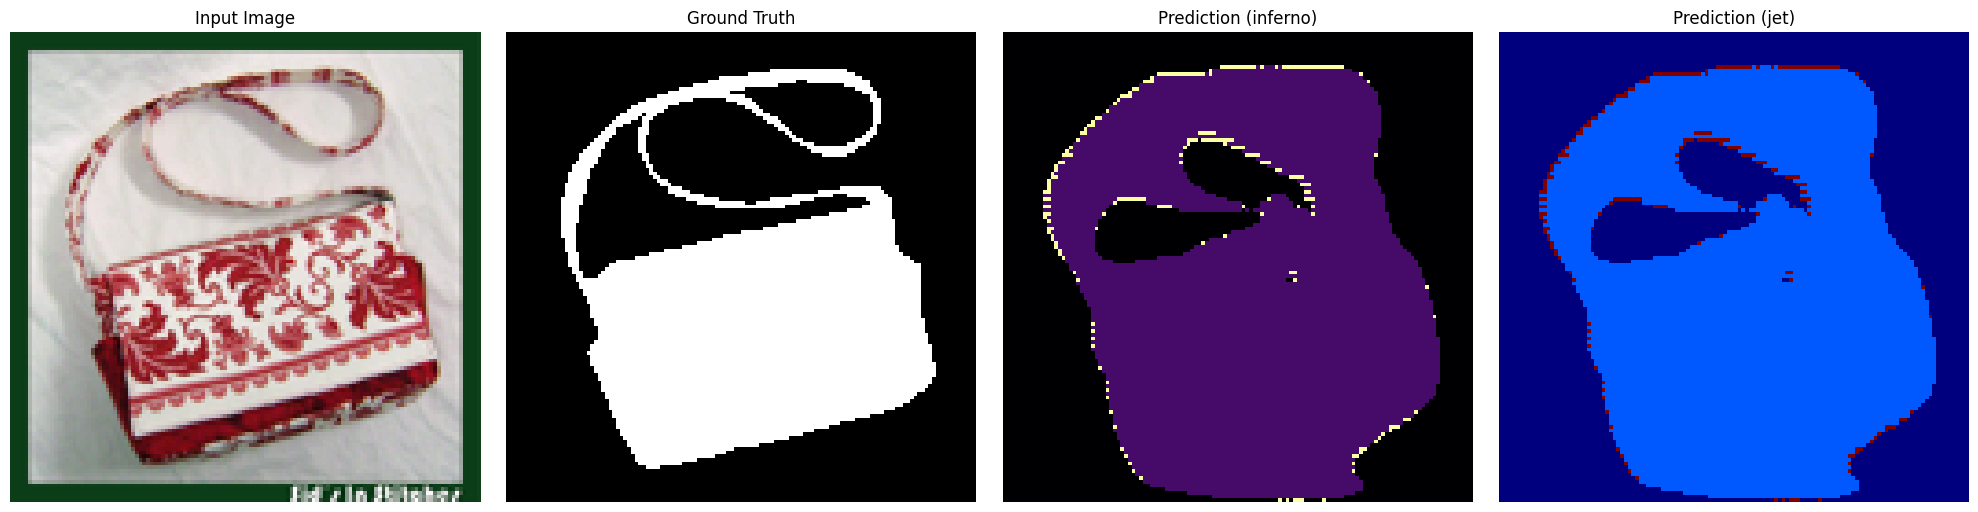

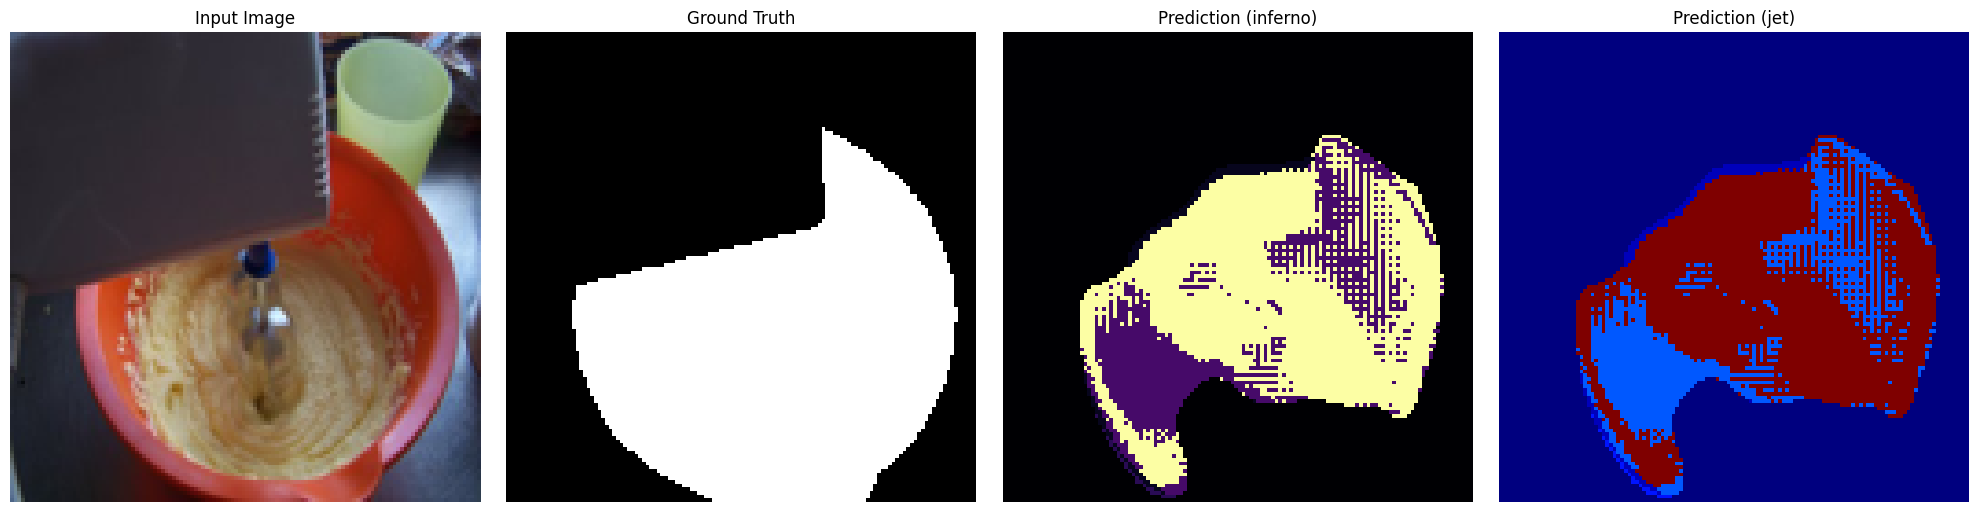

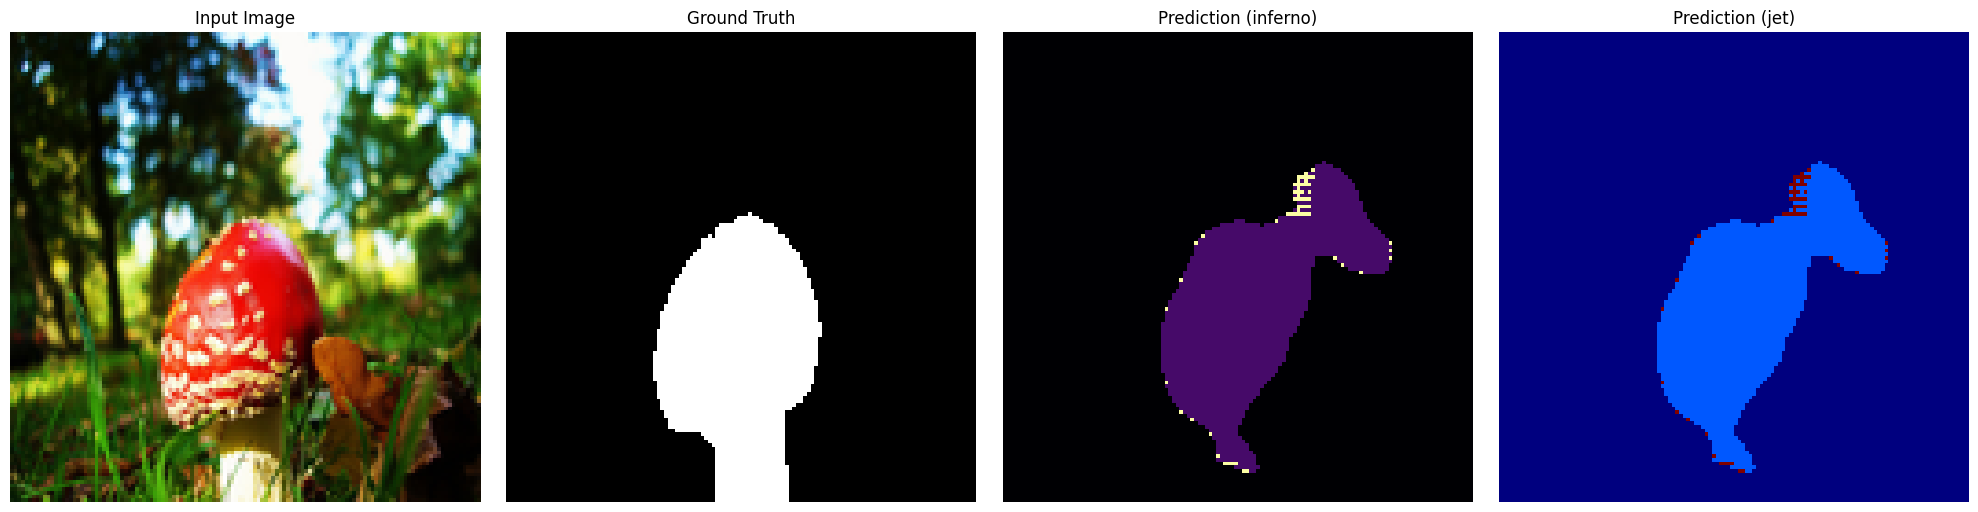

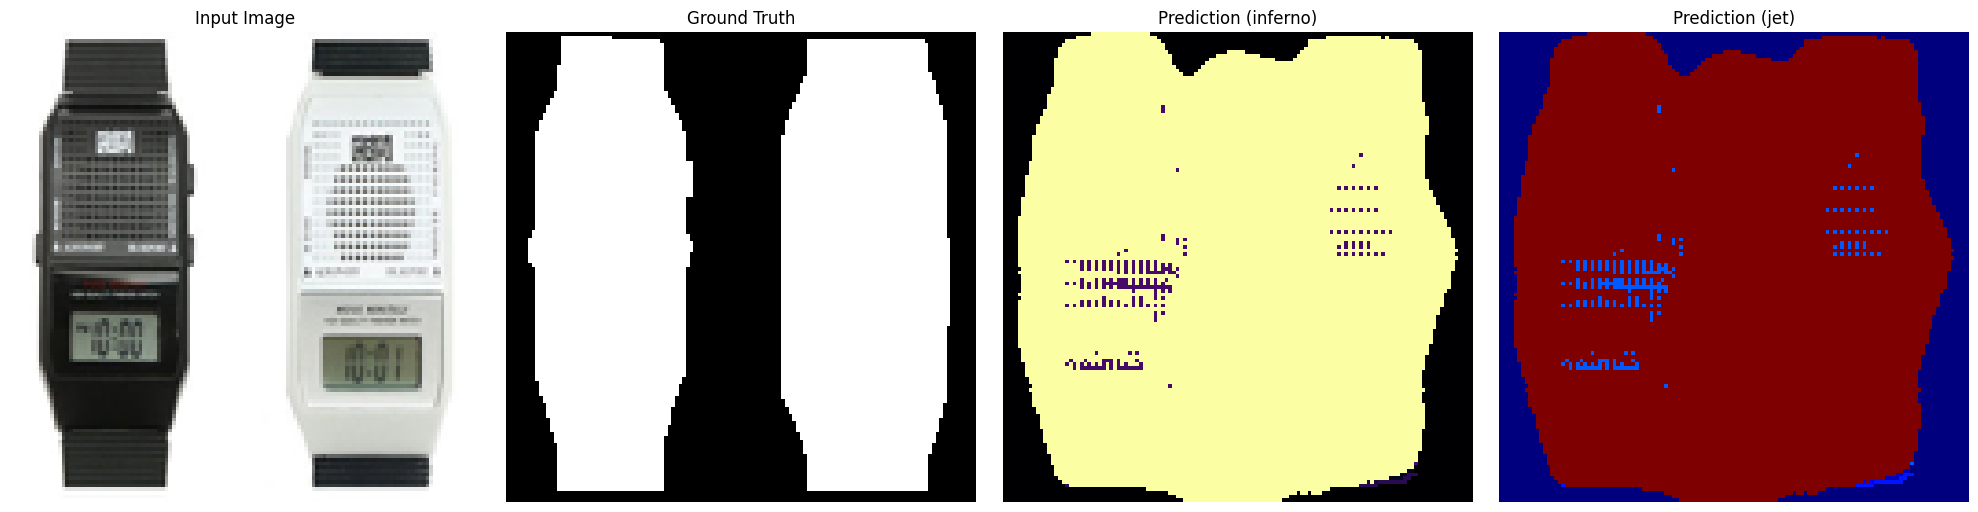

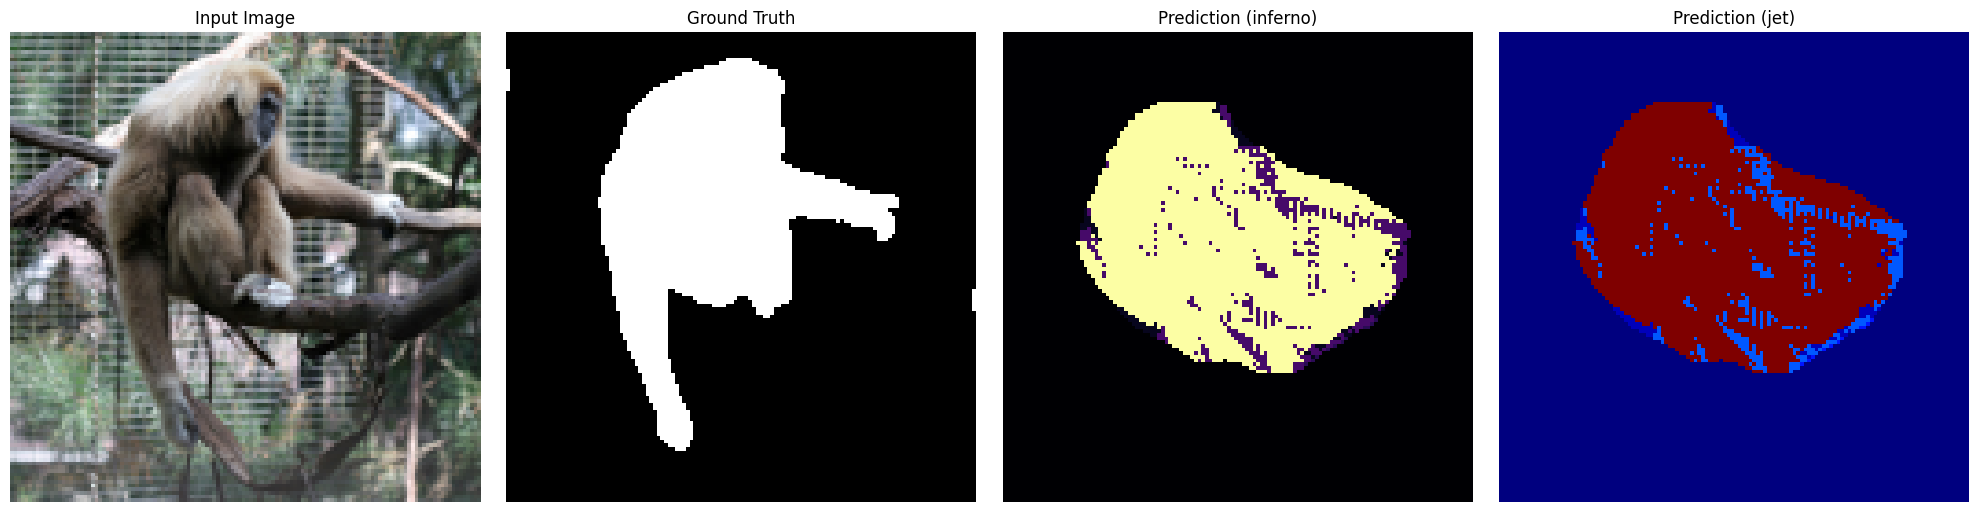

Visualized 5 images. Stopping.


In [ ]:
def visualize_prediction(model, data_loader, device, num_samples=3):
    model.eval() # Set the model to evaluation mode

    visualized_count = 0 # Counter for how many images we have visualized

    with torch.no_grad(): # Disable gradient calculations for inference
        for batch_idx, (images, class_id, masks) in enumerate(data_loader):
            images = images.float().to(device)

            # Perform prediction
            outputs = model(images)
            preds = torch.argmax(outputs, dim=1) # Assuming standard segmentation output

            # Iterate through images in the current batch
            for i in range(images.shape[0]): # images.shape[0] is the batch size
                if visualized_count >= num_samples:
                    print(f"Visualized {num_samples} images. Stopping.")
                    return # Stop if we've reached the desired number of samples

                plt.figure(figsize=(20, 5)) # Increased figsize for 4 subplots
                
                # Input Image
                plt.subplot(1, 4, 1)
                display_image_np = images[i].permute(1, 2, 0).cpu().numpy()
                display_image_np = (display_image_np * 255).astype(np.uint8)
                plt.imshow(display_image_np)
                plt.title("Input Image")
                plt.axis('off') # Optional: remove axes for cleaner image display

                # Ground Truth Mask
                plt.subplot(1, 4, 2)
                plt.imshow(masks[i].cpu(), cmap="gray")
                plt.title("Ground Truth")
                plt.axis('off')

                # Prediction with inferno colormap
                plt.subplot(1, 4, 3)
                # Ensure preds[i] is on CPU and correct type if needed (e.g., float or int)
                # For classification predictions, cmap typically expects 0-255 or 0-1 range.
                # If preds are class IDs, they are typically integers.
                plt.imshow(preds[i].cpu().squeeze(), cmap="inferno") # .squeeze() for single-channel
                plt.title("Prediction (inferno)")
                plt.axis('off')

                # Prediction with jet colormap (for comparison)
                plt.subplot(1, 4, 4)
                plt.imshow(preds[i].cpu().squeeze(), cmap="jet") # .squeeze() for single-channel
                plt.title("Prediction (jet)")
                plt.axis('off')

                plt.tight_layout() # Adjust layout to prevent overlap
                plt.show()

                visualized_count += 1

    print(f"Finished visualizing {visualized_count} images from the data loader.")
visualize_prediction(model, dataloader, device, num_samples=5)

In [27]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
import os

class CustomImageDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.image_files = sorted([f for f in os.listdir(root_dir) if f.endswith('.JPEG')])

    def __len__(self):
        return len(self.image_files)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir, self.image_files[idx])
        image = Image.open(img_name).convert('RGB') # Ensure 3 channels
        if self.transform:
            image = self.transform(image)
        return image, self.image_files[idx] # Return image and its filename

transform = transforms.Compose([
    transforms.Resize((224, 224)), # Resize to your model's expected input size
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

# Create the dataset and dataloader
root_folder = 'test' # Your folder name
dataset = CustomImageDataset(root_dir=root_folder, transform=transform)
dataloader = DataLoader(dataset, batch_size=32, shuffle=False, num_workers=4) # Adjust batch_size as needed

# Move model to GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval() # Ensure model is in evaluation mode

predictions = {}
with torch.no_grad(): # Disable gradient calculations for inference
    for inputs, filenames in dataloader:
        inputs = inputs.to(device)
        outputs = model(inputs)

        # Get predicted class (assuming classification model)
        # For a classification model, outputs are usually logits.
        # torch.argmax gives the index of the highest logit.
        _, predicted_class = torch.max(outputs, 1)

        # Store predictions
        for i, filename in enumerate(filenames):
            predictions[filename] = predicted_class[i].item()

# Print some predictions
print("Sample Predictions:")
for i, (filename, pred_class) in enumerate(predictions.items()):
    if i < 10: # Print first 10 predictions
        print(f"File: {filename}, Predicted Class: {pred_class}")
    else:
        break

# You can save your predictions to a CSV or JSON file
import json
with open('predictions.json', 'w') as f:
    json.dump(predictions, f, indent=4)

print("\nPredictions saved to predictions.json")

RuntimeError: a Tensor with 50176 elements cannot be converted to Scalar

In [ ]:
# class UnlabeledImageDataset(Dataset):
#     def __init__(self, root_dir, transform=None):
#         """
#         Args:
#             root_dir (string): Directory with all the images.
#             transform (callable, optional): Optional transform to be applied on a sample.
#         """
#         self.root_dir = root_dir
#         # Get a sorted list of all image filenames in the directory
#         self.image_filenames = sorted([
#             f for f in os.listdir(root_dir) 
#             if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))
#         ])
#         self.transform = transform

#     def __len__(self):
#         return len(self.image_filenames)

#     def __getitem__(self, idx):
#         if torch.is_tensor(idx):
#             idx = idx.tolist()

#         img_name = self.image_filenames[idx]
#         img_path = os.path.join(self.root_dir, img_name)
        
#         image = Image.open(img_path).convert('RGB')

#         if self.transform:
#             image = self.transform(image)

#         # We return only the image, as there are no labels
#         return image

# # --- Define Transformations ---
# image_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
# ])

# # --- Create the Unlabeled Custom Dataset instance ---
# dataset = UnlabeledImageDataset(root_dir="test", transform=None)

# print(f"\nUnlabeled Custom Dataset found {len(dataset)} images.")

# # --- Create a DataLoader ---
# batch_size = 4
# num_workers = 2

# data_loader = DataLoader(
#     dataset,
#     batch_size=batch_size,
#     shuffle=False, # No need to shuffle if labels don't matter or for inference
#     num_workers=num_workers
# )

# print(f"\nDataLoader created with batch size: {batch_size}")
# print(f"Number of batches: {len(data_loader)}")


# # --- Iterate through the DataLoader (Example Usage) ---
# print("\nIterating through the first batch:")
# for batch_idx, images in enumerate(data_loader): # Only images are returned
#     print(f"Batch {batch_idx+1}:")
#     print(f"  Images tensor shape: {images.shape}")
    
#     if batch_idx == 0:
#         print("\nVisualizing the first image from the first batch:")
#         mean = torch.tensor([0.485, 0.456, 0.406]).view(3, 1, 1)
#         std = torch.tensor([0.229, 0.224, 0.225]).view(3, 1, 1)
        
#         img_to_show = images[0] * std + mean
#         img_to_show = img_to_show.numpy().transpose((1, 2, 0))
#         img_to_show = np.clip(img_to_show, 0, 1)

#         plt.imshow(img_to_show)
#         plt.title("Unlabeled Image")
#         plt.axis('off')
#         plt.show()

#     break


Unlabeled Custom Dataset found 752 images.

DataLoader created with batch size: 4
Number of batches: 188

Iterating through the first batch:


TypeError: Caught TypeError in DataLoader worker process 0.
Original Traceback (most recent call last):
  File "/home/charles/.local/lib/python3.10/site-packages/torch/utils/data/_utils/worker.py", line 349, in _worker_loop
    data = fetcher.fetch(index)  # type: ignore[possibly-undefined]
  File "/home/charles/.local/lib/python3.10/site-packages/torch/utils/data/_utils/fetch.py", line 55, in fetch
    return self.collate_fn(data)
  File "/home/charles/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 398, in default_collate
    return collate(batch, collate_fn_map=default_collate_fn_map)
  File "/home/charles/.local/lib/python3.10/site-packages/torch/utils/data/_utils/collate.py", line 240, in collate
    raise TypeError(default_collate_err_msg_format.format(elem_type))
TypeError: default_collate: batch must contain tensors, numpy arrays, numbers, dicts or lists; found <class 'PIL.Image.Image'>


In [ ]:
def save_model_with_timestamp(model, save_dir="models", model_name="my_model"):
    """
    Saves a PyTorch model to a specified directory with a timestamp in its filename.

    Args:
        model (torch.nn.Module): The PyTorch model to save.
        save_dir (str): The directory where the model should be saved.
                        Defaults to "models".
        model_name (str): The base name for the model file.
                          Defaults to "my_model".
    """
    # 1. Ensure the save directory exists
    os.makedirs(save_dir, exist_ok=True)

    # 2. Generate a timestamp
    timestamp = datetime.now().strftime("%Y%m%d_%H%M%S") # Format: YYYYMMDD_HHMMSS

    # 3. Create the full filename with path
    filename = f"{model_name}_{timestamp}.pth" # Using .pth or .pt extension
    filepath = os.path.join(save_dir, filename)

    # 4. Save the model state_dict
    torch.save(model.state_dict(), filepath)
    print(f"Model saved successfully to: {filepath}")

save_model_with_timestamp(model, save_dir=MODEL_SAVE_DIR, model_name="unet_imagenet_subset_segmentation")

Model saved successfully to: saved_models/unet_imagenet_subset_segmentation_20250526_181825.pth
